In [1]:
# PW malikaNotebook

# Importing the packages

import datetime
now = datetime.datetime.now()
import shutil, os
import re
import csv
import math
import statistics
import sys
import openpyxl
import scipy as sc
import numpy as np
import matplotlib.pyplot as plt
import openpyxl
import pandas as pd
from pandas import ExcelWriter

# Eventually change the working directory to be able to import the side functions
#os.chdir()
import calc
import mystat
import testdata


In [2]:

#ref_id='NAT336'   # What's written as Identifier in the file
#ref_id='ref'
#ref_id='COC'
ref_id='CB09285'
#ref_id='CB9285'
#ref_id='NAT350'

#strref='NAT336'   # Real name of the ref that was used
strref='CB09285 new'
#strref='JASKIER'
#strref='COC'

dateformat='%d/%m/%Y %H:%M:%S'
permil=' [\u2030]'
MRname='MR [ppb]'
d13C=' -d13C'
dD=' -dD'
delta_13C='d13C VPDB'
delta_D='dD SMOW'
MRname='MR [ppb]'

plt.rcParams.update({'font.size': 10})

# Limit values for tests [min, max]
lim_peakarea=[2, 13]
lim_peakwidth=[25, 70]

lim_isotop_d13C=[-70, -20]
lim_isotop_dD=[-270, -50]

peakstart_13C=250
peakend_13C=340

peakstart_D=200
peakend_D=260


In [3]:
#*****************************************************************************
# Data files
#*****************************************************************************

# MODIFY HERE
# ---------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------

pathname=os.getcwd()

# Path of the csv file from Isodat
filepath='/Users/malika/surfdrive/Data/Zeppelin/UHEI 2020/Input files/'    
# Name of the file
# ATTENTION the file must be with ',' separator, and '.' decimal separator
filename='d13C_2020-12-08-bis'

# Output file name:
outname='d13C_2020-12-08-bis'
# Output stored here (local folder)
outloc='/Users/malika/Documents/Scripts/results/'+outname+'_out'

# Isotopologue that was measured
# 1 for carbon13
# 2 for deuterium
isotop=1

# Volume that is measured (in ml)
# 'y' if in column -> check 'col_vol' value l.146
# 'n' to set manually -> 'vol' value 
vol_check='y'
vol=60

# To force interpolation
interpol_areas=0
interpol_sigs=0

# Isodat column names
col_peak='Peak Nr'
col_an='Analysis'
col_id='Identifier 1'
col_peakarea='Area All'
col_peakwidth='Width'
col_peakstart='Start'
col_time='Time Code'
#col_vol='Identifier 2'
col_vol='Comment'


In [ ]:
#*****************************************************************************
# Reading the file and tests
#*****************************************************************************

# Open the file ... check date format
data=pd.read_csv(filepath+filename+'.csv', encoding='utf-8-sig', parse_dates=[col_time], dayfirst=True)

# Check if the file is full

datanum=len(data)

if datanum==0:
    print('The data file is empty!')
    print('Goodbye.')
    sys.exit()
else:
    print('The data is now accessible. It has '+str(datanum-1)+' entries.')

# If the volumes are not stated, put them in the right column

if vol_check=='n':
    data[col_vol]=vol
    
data=data.replace(ref_id, strref)   # make sure the ref id is recognisable

# For d13C or dD data, get only methane peak based on the timing

methane=[]

if isotop==1:
    striso='13C'
    methane=data.loc[(data[col_peakstart]>peakstart_13C) & (data[col_peakstart]<peakend_13C)]
    lim_isotop=lim_isotop_d13C
    col_sig='d 13C/12C'
    delta='d13C'
    col_delta='d13C VPDB'
    strdelta='\u03B4\u00B9\u00B3C V-PDB [\u2030]'

elif isotop==2:
    striso='dD'
    methane=data.loc[(data[col_peakstart]>peakstart_D) & (data[col_peakstart]<peakend_D)]
    lim_isotop=lim_isotop_dD
    col_sig='d 2H/1H'
    delta='dD'
    col_delta='dD SMOW'
    strdelta='\u03B4D V-SMOW [\u2030]'

methdata=methane.dropna(how='any', subset=[col_sig])  # Remove rows with no isotope data

# Show the peak numbers

print('Methane data was extracted for a number of '+str(len(methdata))+' measures:')
print(str(methdata[[col_an, col_id, col_peak, col_peakarea, col_sig]]))

# Tests on the raw data: peak area, peak width and raw isotopic signature

testdata.test2(methdata, col_peakarea, lim_peakarea, 'peak area')
testdata.test2(methdata, col_peakwidth, lim_peakwidth, 'peak width')
testdata.test2(methdata, col_sig, lim_isotop, delta+' isotopic signature')


The data is now accessible. It has 69 entries.
Methane data was extracted for a number of 15 measures:
    Analysis Identifier 1  Peak Nr  Area All  d 13C/12C
3      26081  CB09285 new        4   9.10680    -47.389
7      26083  CB09285 new        4   9.02928    -47.114
11     26085  CB09285 new        4   8.99141    -47.067
19     26089    Q81 22-03        4   1.51955    -46.143
24     26091   Q101 24-05        4   6.24711    -46.585
28     26093   Q101 24-05        4   0.79304    -46.483
33     26095  CB09285 new        4   8.96141    -46.628
37     26097  CB09285 new        4   8.97255    -46.737
41     26099  CB09285 new        4   8.93850    -46.838
45     26101    Q93 25-04        4   8.83823    -46.668
49     26103    Q93 25-04        4   2.59071    -46.408
53     26105    Q97 10-05        4   8.74955    -46.650
61     26109  CB09285 new        4   8.92669    -46.713
65     26111  CB09285 new        4   8.90270    -46.888
69     26113  CB09285 new        4   8.91396    -46.805


In [5]:
#*****************************************************************************
# Seperate sample and ref data
#*****************************************************************************

# Now we'll extract the samples rows and the ref rows, based on the Identifier 1 (name of the reference gas)

def separe_sp_ref(df_all):
    
    df_all.reset_index(drop=True, inplace=True)           # re-order the row indices
    
    df_ref=df_all.loc[df_all[col_id]==strref]   # get the refs
    df_ref.reset_index(drop=True, inplace=True)             # re-order the row indices
    
    while df_all[col_an][0]<df_ref[col_an][0]:      # check if the first analysis is a ref
        df_all=df_all.drop(df_all.index[0])    # if not, drop the row until it is
        df_all.reset_index(drop=True, inplace=True)
        
    while (df_all[col_an].iloc[-1]>df_ref[col_an].iloc[-1]):   # check if the last analysis is a ref
        df_all=df_all.drop(df_all.index[-1])               # if not, drop the row until it is
        df_all.reset_index(drop=True, inplace=True)
    
    df_sample=df_all.loc[df_all[col_id]!=strref]    # get the samples
    df_sample.reset_index(drop=True, inplace=True)              # re-order the row indices
    
    return df_all, df_sample, df_ref
    
methdata, samples, refs = separe_sp_ref(methdata)   

# Show the analysis numbers of the air and refs

indexref=refs[col_an]
print('************\nAnalysis numbers of the reference gas:')
print(delta+'\n'+str(indexref))

index=samples[col_an]
if samples.empty==False:
    print('************\nAnalysis numbers of the samples measurements:')
    print(delta+'\n'+str(index))
elif samples.empty==True:
    print('************\nNo samples were measured.\n')


************
Analysis numbers of the reference gas:
d13C
0    26081
1    26083
2    26085
3    26095
4    26097
5    26099
6    26109
7    26111
8    26113
Name: Analysis, dtype: int64
************
Analysis numbers of the samples measurements:
d13C
0    26089
1    26091
2    26093
3    26101
4    26103
5    26105
Name: Analysis, dtype: int64



**********************
Distribution statistics
std(peak area) = 0.06
std(raw signatures) = 0.23

**********************
Shapiro-Wilk test
alpha = 0.05
areas: passed
signatures: passed

**********************
Correlation test
r < 0.5
areas: failed
signatures: failed


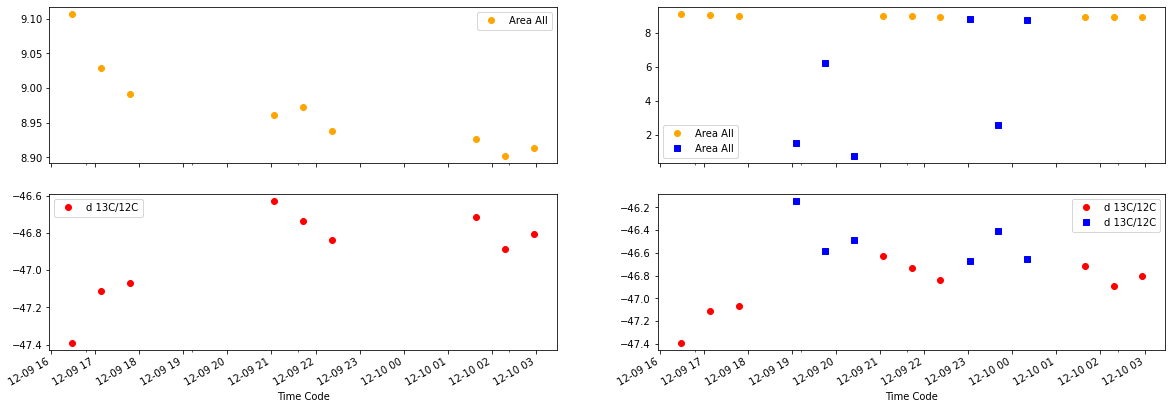

In [6]:
#*****************************************************************************
# Test the stability of the measurements
#*****************************************************************************

ref_areas = refs[col_peakarea]
ref_sigs = refs[col_sig]
ref_time = refs[col_time]
    
alpha = 0.05        # For the normality test
r_lim=0.5          # For the correlation test

# Compute the standard deviation of peak areas and raw signatures for the working standards
areas_s = np.std(ref_areas)
sigs_s = np.std(ref_sigs)
print('\n**********************\nDistribution statistics\nstd(peak area) = %0.2f' % areas_s+'\nstd(raw signatures) = %0.2f' % sigs_s)

print('\n**********************\nShapiro-Wilk test\nalpha = '+str(alpha))
areas_p, areas_norm = testdata.normality(ref_areas, 'areas', alpha)
sigs_p, sigs_norm = testdata.normality(ref_sigs, 'signatures', alpha)
    
print('\n**********************\nCorrelation test\nr < '+str(r_lim))
areas_r, areas_corr = testdata.correlation(ref_areas, ref_time, 'areas', r_lim)
sigs_r, sigs_corr = testdata.correlation(ref_sigs, ref_time, 'signatures', r_lim)
    
# Plot an overview of the results
if samples.empty==False:        # With sample measurements
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 7), sharex=True)
    ax1=axes[0,0]
    ax2=axes[1,0]
    ax3=axes[0,1]
    ax4=axes[1,1]
    refs.plot(y=col_peakarea, x=col_time, ax=ax1, style='o', mfc='orange', mec='orange')
    refs.plot(y=col_sig, x=col_time, ax=ax2, style='o', mfc='red', mec='red')

    refs.plot(y=col_peakarea, x=col_time, ax=ax3, style='o', mfc='orange', mec='orange')
    samples.plot(y=col_peakarea, x=col_time, ax=ax3, style='s', mfc='blue', mec='blue')
    refs.plot(y=col_sig, x=col_time, ax=ax4, style='o', mfc='red', mec='red')
    samples.plot(y=col_sig, x=col_time, ax=ax4, style='s', mfc='blue', mec='blue')
    
elif samples.empty==True:       # If no sample measurements
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,7), sharex=True)
    ax1=axes[0]
    ax2=axes[1]
    refs.plot(y=col_peakarea, x=col_time, ax=ax1, style='o', mfc='orange', mec='orange')
    refs.plot(y=col_sig, x=col_time, ax=ax2, style='o', mfc='red', mec='red')

# Save the figure 
fig.savefig(outloc+'.png', dpi=300)


In [7]:
#*****************************************************************************
# Decide on inerpolation
#*****************************************************************************

if (areas_norm == 0) or (areas_corr == 1):
    print('\n**********************\nWarning: peak area data doesn''t look stable. The values will be interpolated.')
    ans=input()
    interpol_areas=1
    if ans=='no':       # If you don't accept the interpolation
        interpol_areas=0
        print('\nThe peak areas won''t be interpolated. The reference will be the average between the previous and following working standards.\n')
if (sigs_norm == 0) or (sigs_corr == 1):
    print('**********************\nWarning: isotopic signature data doesn''t look stable. The values will be interpolated.')
    ans=input()
    interpol_sigs=1
    if ans=='no':       # If you don't accept the interpolation
        interpol_sigs=0
        print('\nThe isotope values won''t be interpolated. The reference will be the average between the previous and following working standards.\n')

# summary of stability results for exporting in excel
df_stab = pd.DataFrame({'Stdev':[areas_s, sigs_s], 'ShapiroWilk p':[areas_p, sigs_p], 'Corr r2':[areas_r, sigs_r], 'Interpolation':[interpol_areas, interpol_sigs]},
                        columns=['Stdev', 'ShapiroWilk p', 'Corr r2', 'Interpolation'], index=[ col_peakarea, col_sig])



**********************

**********************



In [9]:
#*****************************************************************************
# Calculating the values and export them
#*****************************************************************************

def processing (df_all_in, samples, refs, iso):
    
    # sort the index from 0 for the specific data, and according to analysis number for the general data
    df_all=df_all_in.sort_values(by=col_an)
    df_all.reset_index(drop=True, inplace=True)

    n=len(df_all)
    
    print('\n********************\n'+delta+' - '+str(n)+' measurements\n********************')
        
    # Get the first reference analysis numbers of each set
    newref=[df_all[col_an][0]]
    for i in range(n-1):
        if (df_all[col_id][i+1]==strref) & (df_all[col_id][i]!=strref): # when there is a new set of refs
            newref.append(df_all[col_an][i+1])
    
    numset=len(newref)-1
    print('\nNumber of sets: '+str(numset))
    
    all_MRs=[]
    all_signatures=[]
    all_err_refMR=[]
    all_err_refsig=[]
    n_ref=[]
    
    for k in range(numset):
        
        # condition for the last set
        if k==numset-1:
            set_ref_prev=refs.loc[(refs[col_an]>=newref[k]) & (refs[col_an]<newref[k+1])]
            set_ref_foll=refs.loc[(refs[col_an]>=newref[k+1])]
            
        else:
            set_ref_prev=refs.loc[(refs[col_an]>=newref[k]) & (refs[col_an]<newref[k+1])]     # select the set of ref before and after each change
            set_ref_foll=refs.loc[(refs[col_an]>=newref[k+1]) & (refs[col_an]<newref[k+2])] 
            
        # the set of ref will be all 3 previous and following
        set_ref=pd.concat([set_ref_prev, set_ref_foll]) 
        set_ref.reset_index(drop=True, inplace=True)
        
        # select the corresponding set of samples
        set_sample=samples.loc[(samples[col_an]>set_ref[col_an][0]) & (samples[col_an]<set_ref[col_an].iloc[-1])] 
        set_sample.reset_index(drop=True, inplace=True)
        
        time_ref=pd.to_numeric(set_ref[col_time], downcast='float')     # convert times into numeric
        time_sp=pd.to_numeric(set_sample[col_time], downcast='float')
        
        if interpol_areas == 1:   # Case where we need to interpolate from the refs, because they are not stable
            peakarea_ref=np.interp(time_sp, time_ref, set_ref[col_peakarea])   
        if interpol_sigs == 1:
            signature_ref=np.interp(time_sp, time_ref, set_ref[col_sig])

        # If no interpolation, we keep only the last 2 of the 3 refs in the previous and following sets, rest is dropped.
        if len(set_ref_prev)>2:
            set_ref_prev=set_ref_prev[-2:]
        if len(set_ref_foll)>2:
            set_ref_foll=set_ref_foll[-2:]
        if len(set_ref_prev)!=len(set_ref_foll):
            print('WARNING! Unbalanced number of references')
                
        set_ref=pd.concat([set_ref_prev, set_ref_foll])
        set_ref.reset_index(drop=True, inplace=True)
        
        volume_ref=np.mean(set_ref[col_vol])     # get the reference volume
        
        peakareas=set_sample[col_peakarea]                   # get the air/samples peak areas
        volumes=set_sample[col_vol]                          # get the air/samples volumes
        signatures=set_sample[col_sig]                       # get the air/samples volumes

        if interpol_areas == 0:
            peakarea_ref=[np.mean(set_ref[col_peakarea])] * len(set_sample)         # get the reference peak area in an array
        if interpol_sigs == 0:            
            signature_ref=[np.mean(set_ref[col_sig])] * len(set_sample)          # get the reference raw signature in an array
            
        # For both cases, the uncertainteties will be from the mean
        err_peakarea_ref=np.std(set_ref[col_peakarea])    
        err_sigs_ref=np.std(set_ref[col_sig])
                      
        # Calculation of the mixing ratios
        set_MR, set_err_refMR = calc.MR(peakareas, volumes, peakarea_ref, err_peakarea_ref, volume_ref, strref)
        
        # Calculation of the standardised isotopic signatures
        set_sig = calc.iso3(signatures, signature_ref,  iso, strref)
        
        for q in range(len(set_sample)):                                             # adding the new calculated value to a general serie
            all_MRs.append(set_MR[q])
            all_signatures.append(set_sig[q])
            all_err_refMR.append(set_err_refMR[q])
            all_err_refsig.append(err_sigs_ref)
            n_ref.append(len(set_ref))
    
        #str_set = 
        # Print things to know where you are
        print('\nSet #'+str(k+1)+':\nreferences\n'+str(set_ref[[col_time, col_an, col_id, col_peakarea, col_sig]])+'\nsamples\n'+str(set_sample[[col_time, col_an, col_id, col_peakarea, col_sig]]))
        
        
        if interpol_areas == 1:
             print('\nInterpolated ref peak area values:\n'+str(peakarea_ref)+'\nerror:\n'+str(err_peakarea_ref))
             
        if interpol_sigs == 1:
            print('\nInterpolated ref raw signatures values:\n'+str(signature_ref)+'\nerror:\n'+str(err_sigs_ref))
             
    df_results=pd.DataFrame({col_an:samples[col_an], col_time:samples[col_time], col_id:samples[col_id], col_vol:samples[col_vol], MRname: all_MRs, delta: all_signatures, 'n_refs': n_ref ,'err_refMR [ppb]': all_err_refMR, 'err_refdelta'+permil: all_err_refsig}, 
    columns=[col_an, col_time, col_id, col_vol, MRname, delta, 'n_refs', 'err_refMR [ppb]', 'err_refdelta'+permil])
              
    return newref, numset, df_results
 
refchange, numset, results = processing (methdata, samples, refs, isotop)



********************
d13C - 15 measurements
********************

Number of sets: 2

Set #1:
references
            Time Code  Analysis Identifier 1  Area All  d 13C/12C
0 2020-12-09 17:08:00     26083  CB09285 new   9.02928    -47.114
1 2020-12-09 17:48:00     26085  CB09285 new   8.99141    -47.067
2 2020-12-09 21:43:00     26097  CB09285 new   8.97255    -46.737
3 2020-12-09 22:22:00     26099  CB09285 new   8.93850    -46.838
samples
            Time Code  Analysis Identifier 1  Area All  d 13C/12C
0 2020-12-09 19:06:00     26089    Q81 22-03   1.51955    -46.143
1 2020-12-09 19:45:00     26091   Q101 24-05   6.24711    -46.585
2 2020-12-09 20:25:00     26093   Q101 24-05   0.79304    -46.483

Interpolated ref peak area values:
[8.97954953 8.9736193  8.96734023]
error:
0.03279482466792607

Interpolated ref raw signatures values:
[-46.89344186 -46.80666279 -46.71477907]
error:
0.15653593836560423

Set #2:
references
            Time Code  Analysis Identifier 1  Area All  d 13C/12C


In [ ]:
#*****************************************************************************
# Write everything in the excel file
#*****************************************************************************

date=now.strftime('%Y-%m-%d')
time=now.strftime('%H%M%S')
print('**********************\nWriting the results in an Excel file...')

# Open the result files
writer = ExcelWriter(outloc+'.xlsx', engine='xlsxwriter')

# Write the raw data in the first sheet
data.to_excel(writer, sheet_name='isodat', index=False)

# Write the methane data in the second sheet
methdata.to_excel(writer, sheet_name='raw methane', index=False)

# Write the stability results in the third sheet
df_stab.to_excel(writer, sheet_name='stability', float_format='%0.2f')
refs.to_excel(writer, sheet_name='stability', index=False, startrow=len(df_stab)+2, columns=[col_an, col_time, col_id, col_vol, col_peakarea, col_sig])

# Write the processed data in the fourth sheet
results.to_excel(writer, sheet_name='processed', index=False)

# Now we want to average the duplicate measurements
    
names=samples[col_id]
    
[avgMR, errMR, avgsig, errsig, n, avgV]=mystat.avg(results[MRname], results[delta], names, results[col_vol])
    
n_tot=len(avgMR)
n_out=len(results)
   
summary=pd.DataFrame({col_id:avgMR.index, MRname+' -'+delta:avgMR,'err_'+MRname+' -'+delta:errMR, strdelta:avgsig, 'err_'+strdelta:errsig, 'n':n, 'vol [ml]':avgV},
                            columns=[col_id, MRname+' -'+delta, 'err_'+MRname+' -'+delta, strdelta, 'err_'+strdelta, 'n', 'vol [ml]'])
    
summary.to_excel(writer, sheet_name='processed', index=False, startcol=0, startrow=n_out+2, float_format='%0.2f')
    
# save the output file
writer.save()

print('\n********************\nResults successfuly saved in file '+outloc+'.xslx\n********************')